# DCGAN MNIST

This notebook is for implementing `Deep Convolution Generative Adversarial Network(DCGAN)` from the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

## Parameters


In [3]:
img_size   = 28

batch_size = 128
num_epoch  = 50

n_latent = 100

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_epoch = 5

gpu_fraction = 0.3 

## Import CelebA Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 7*7*1024], initializer=xavier_init)
        b1 = tf.get_variable('b1', [7*7*1024], initializer=xavier_init)
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 1024))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, is_trainint, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1, kernel_initializer=xavier_init)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [8]:
def GAN(x, z, is_training):
    # Generator
    G = Generator(z, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, is_training, reuse=True)
    
    # get loss
    d_loss = -(tf.reduce_mean(tf.log(D_out_real + 1e-8)) + tf.reduce_mean(tf.log( (1-D_out_fake) + 1e-8)))
    g_loss = -tf.reduce_mean(tf.log(D_out_fake + 1e-8))

    return d_loss, g_loss , G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Train

Epoch: 1 / G Loss: 10.59461 / D Loss: 0.02865


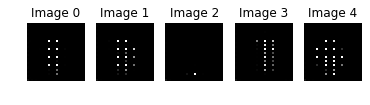

Epoch: 2 / G Loss: 4.34053 / D Loss: 0.14958
Epoch: 3 / G Loss: 7.50024 / D Loss: 0.22024
Epoch: 4 / G Loss: 3.92245 / D Loss: 0.20881
Epoch: 5 / G Loss: 3.70780 / D Loss: 0.25536


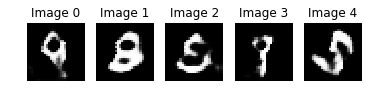

Epoch: 6 / G Loss: 2.94851 / D Loss: 0.59389
Epoch: 7 / G Loss: 2.27975 / D Loss: 0.51168
Epoch: 8 / G Loss: 4.18729 / D Loss: 0.08719
Epoch: 9 / G Loss: 3.51640 / D Loss: 0.30919
Epoch: 10 / G Loss: 3.83974 / D Loss: 0.09657


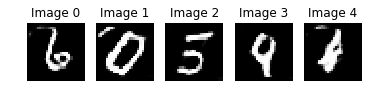

Epoch: 11 / G Loss: 3.94066 / D Loss: 0.07952
Epoch: 12 / G Loss: 2.41706 / D Loss: 0.37098
Epoch: 13 / G Loss: 2.33838 / D Loss: 0.30949
Epoch: 14 / G Loss: 2.78195 / D Loss: 0.42390
Epoch: 15 / G Loss: 3.08546 / D Loss: 0.46906


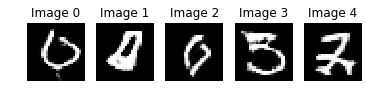

Epoch: 16 / G Loss: 2.03433 / D Loss: 0.52508
Epoch: 17 / G Loss: 1.63275 / D Loss: 0.44153
Epoch: 18 / G Loss: 2.77452 / D Loss: 0.58386
Epoch: 19 / G Loss: 1.42186 / D Loss: 0.68596
Epoch: 20 / G Loss: 2.81199 / D Loss: 0.44011


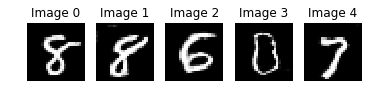

Epoch: 21 / G Loss: 3.82237 / D Loss: 0.36570
Epoch: 22 / G Loss: 2.45161 / D Loss: 0.44742
Epoch: 23 / G Loss: 2.58390 / D Loss: 0.54099
Epoch: 24 / G Loss: 1.82139 / D Loss: 0.47354
Epoch: 25 / G Loss: 2.73914 / D Loss: 0.40203


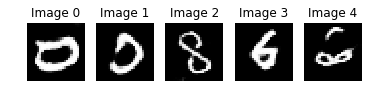

Epoch: 26 / G Loss: 2.06634 / D Loss: 0.61308
Epoch: 27 / G Loss: 2.16785 / D Loss: 0.65721
Epoch: 28 / G Loss: 1.59178 / D Loss: 0.77918
Epoch: 29 / G Loss: 2.43906 / D Loss: 0.53724
Epoch: 30 / G Loss: 1.25947 / D Loss: 0.81095


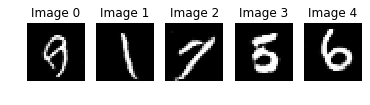

Epoch: 31 / G Loss: 2.72642 / D Loss: 0.57808
Epoch: 32 / G Loss: 2.32391 / D Loss: 0.65971
Epoch: 33 / G Loss: 2.72957 / D Loss: 0.55927
Epoch: 34 / G Loss: 2.00618 / D Loss: 0.48737
Epoch: 35 / G Loss: 2.80375 / D Loss: 0.41302


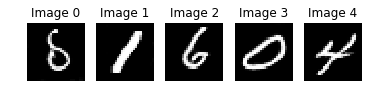

Epoch: 36 / G Loss: 1.89606 / D Loss: 0.57942
Epoch: 37 / G Loss: 2.39396 / D Loss: 0.44283
Epoch: 38 / G Loss: 2.42961 / D Loss: 0.32272
Epoch: 39 / G Loss: 2.43546 / D Loss: 0.61123
Epoch: 40 / G Loss: 2.52779 / D Loss: 0.39036


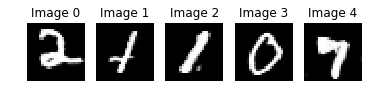

Epoch: 41 / G Loss: 2.15109 / D Loss: 0.49748
Epoch: 42 / G Loss: 2.65578 / D Loss: 0.20188
Epoch: 43 / G Loss: 3.35273 / D Loss: 0.36784
Epoch: 44 / G Loss: 1.55893 / D Loss: 0.53484
Epoch: 45 / G Loss: 1.92429 / D Loss: 0.49355


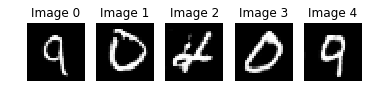

Epoch: 46 / G Loss: 3.08916 / D Loss: 0.51786
Epoch: 47 / G Loss: 2.13303 / D Loss: 0.40073
Epoch: 48 / G Loss: 2.26802 / D Loss: 0.42814
Epoch: 49 / G Loss: 3.09577 / D Loss: 0.57272
Epoch: 50 / G Loss: 3.39528 / D Loss: 0.78465


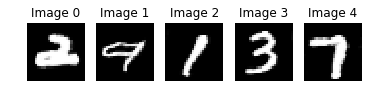

In [11]:
# Training
data_x = x_train
len_data = x_train.shape[0]

for i in range(num_epoch):
    # Shuffle the data 
    np.random.shuffle(data_x)
      
    # Making mini-batch
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
        
        data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))
        
        sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))
        
        # Run Optimizer!
        _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
        _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
    
    # Print Progess
    print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))
    
    # Show test images 
    z_test = np.random.uniform(-1, 1, size=(5, n_latent))
    G_out = sess.run(G, feed_dict = {z: z_test, is_training: False})
        
    if i == 0 or (i+1) % show_result_epoch == 0:
        f, ax = plt.subplots(1,5)
        for j in range(5):
            ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
            ax[j].axis('off')
            ax[j].set_title('Image '+str(j))

    plt.show()

## Image Generation

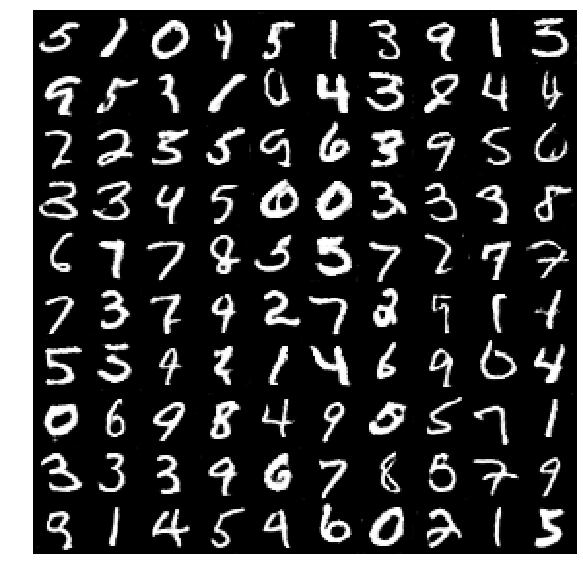

In [12]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result, is_training: False})

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = G_result[i,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()